In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.sparse import random
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import scipy.stats as stats
import seaborn

# NOTE: I am ignoring the max iteration warnings for nmf
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import importlib
importlib.reload(sparse_nmf)
from sparse_nmf import SparseNMF

### Testing with Synthetic Data

In [2]:
def gen_data():
    # generates testing data and saves it so I can test in matlab as well
    test_h = random(4,100, density = 0.10).A
    H = pd.DataFrame(test_h)

    x = np.linspace(1,10,100)
    y1 = stats.norm.pdf(x, 5) * 20
    y2 = []
    y3 = []
    y4 = []
    for i in x:
        y2.append((i - 5)**2)
        y3.append(2 * i)
        y4.append((i - 5)**3/10 + 10)
    y4 = np.array(y4)

    W = pd.DataFrame(np.array([y1, y2, y3, y4]).T)

    return W,H

In [3]:
W,H = gen_data()
X = np.dot(W,H)

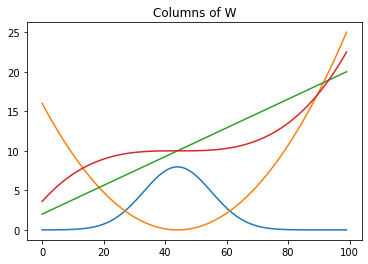

In [4]:
for col in W:
    plt.plot(W.loc[:,col])
    plt.title("Columns of W")

Text(0.5, 1.0, 'Sparse H')

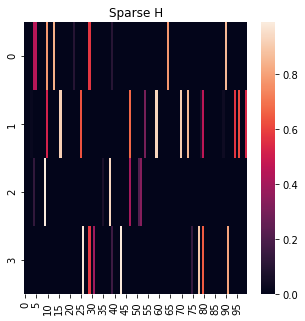

In [5]:
plt.figure(figsize = (5,5))
seaborn.heatmap(H, square = False, cbar = True)
plt.title("Sparse H")

In [6]:
# sparseness of H
h_sparse = 0
for row in H.index:
    rh = np.array(H.loc[row,:])
    sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
    sp /= (math.sqrt(len(rh)) - 1)
    h_sparse += sp
    
h_sparse /= len(H.index)
print(h_sparse)
    

0.8110865860136337


In [7]:
# sparseness of W
w_sparse = 0
for col in W.columns:
    cw = np.array(W.loc[:,col])
    sp = math.sqrt(len(cw)) - (sum(np.abs(cw))/ math.sqrt(sum(cw ** 2)))
    sp /= (math.sqrt(len(cw)) - 1)
    w_sparse += sp
    
w_sparse /= len(W.columns)
print(w_sparse)

0.22200186015790294


### Comparing SparseNMF with Sklearn NMF

In [8]:
model = SparseNMF(X, 4, iterations = 500, sH = 0.81)    
model.solver()
spW = pd.DataFrame(model.W)
spH = pd.DataFrame(model.H)

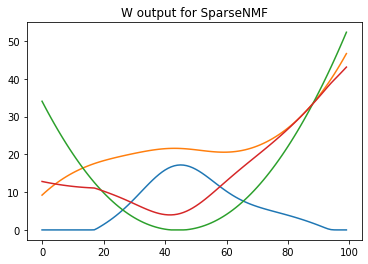

In [9]:
for col in spW:
    plt.plot(spW.loc[:,col])
    plt.title("W output for SparseNMF")

Text(0.5, 1.0, 'H output for SparseNMF')

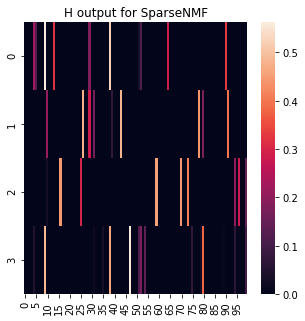

In [10]:
plt.figure(figsize = (5,5))
seaborn.heatmap(spH, square = False, cbar = True)
plt.title("H output for SparseNMF")

In [11]:
# ERRors
print("SparseNMF error on W:", np.linalg.norm(W - spW/1.7))
print("SparseNMF error on H:", np.linalg.norm(H - spH))
print("SparseNMF error on X:", np.linalg.norm(X - np.dot(spW, spH)))

SparseNMF error on W: 125.56341901980178
SparseNMF error on H: 4.077491819583051
SparseNMF error on X: 41.100386267076146


In [12]:
model2 = NMF(n_components = 4, init = 'random', random_state = 35, max_iter = 500)
sciW = pd.DataFrame(model2.fit_transform(X))
sciH = pd.DataFrame(model2.components_)

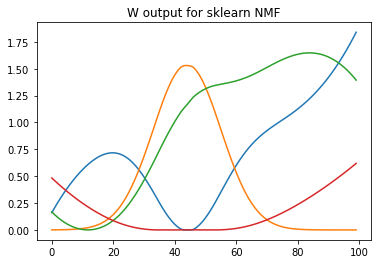

In [13]:
for col in sciW:
    plt.plot(sciW.loc[:,col])
    plt.title("W output for sklearn NMF")

Text(0.5, 1.0, 'H output for Sklearn NMF')

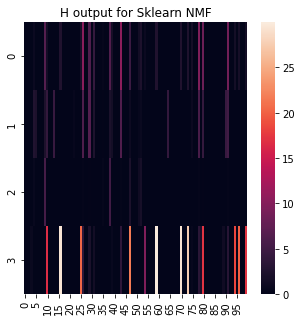

In [14]:
plt.figure(figsize = (5,5))
seaborn.heatmap(sciH, square = False, cbar = True)
plt.title("H output for Sklearn NMF")

In [15]:
print("Scipy error on W:", np.linalg.norm(W - sciW))
print("Scipy error on H:", np.linalg.norm(H - sciH))
print("Scipy error on X:", np.linalg.norm(X - np.dot(sciW, sciH)))

Scipy error on W: 190.33781330190212
Scipy error on H: 83.60400712041135
Scipy error on X: 0.26053927647503766
